# ECG Heart condition classification

In [5]:
!pip install catboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_sample_weight

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import kagglehub

import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Run this cell after the imports and mounting the drive.
# The 'pd' name will now be defined because the first cell was executed.
df = pd.read_csv("/content/drive/MyDrive/archive (1)/mitbih_train.csv", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### First, let's understand the dataset.

This data is from [ECG Heartbeat Categorization Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat/data?select=mitbih_train.csv)

Each row in our dataset represents a single heartbeat, captured as an ECG signal:

- **The First 187 Columns (0-186)**: These are the sequential data points that form the ECG waveform. Each column represents a moment in time, capturing the electrical activity of the heart.

- **The Last Column (187)**: This is the classification label that indicates the type of heartbeat:
    - **0**: Normal beat (N)
    - **1**: Supraventricular premature beat (S)
    - **2**: Premature ventricular contraction (V)
    - **3**: Fusion of ventricular and normal beat (F)
    - **4**: Unclassifiable beat (Q)

When visualized, these 187 data points create the characteristic ECG wave pattern that cardiologists use to diagnose heart conditions.


In [7]:
conditions = {
    0: "Normal (N)",
    1: "Supraventricular premature (S)",
    2: "Premature ventricular contraction (V)",
    3: "Fusion of ventricular and normal beat (F)",
    4: "Unclassifiable beat (Q)"
}

### Let's see an example

In [8]:
df.iloc[0, :187]

,0
0,0.977941
1,0.926471
2,0.681373
3,0.245098
4,0.154412
...,...
182,0.000000
183,0.000000
184,0.000000
185,0.000000


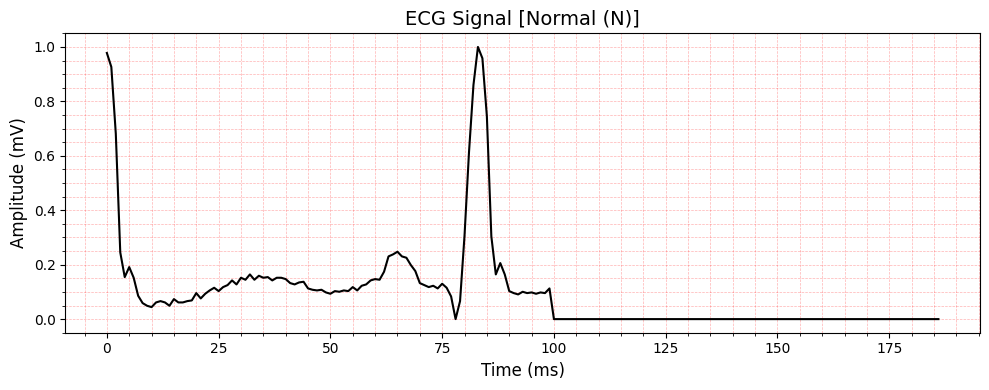

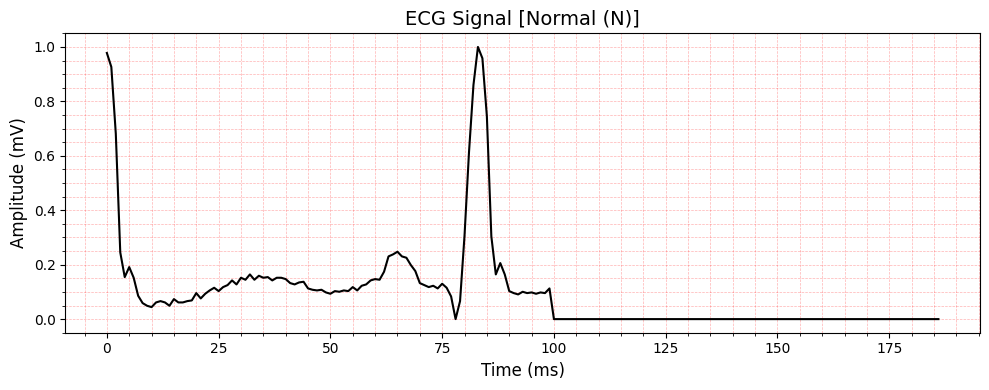

In [10]:
row = df.iloc[0, :187]
condition = df.iloc[0, 187]
condition = conditions[condition]

plt.figure(figsize=(10, 4))
plt.plot(row[0:187], color='black', linewidth=1.5)
plt.title(f"ECG Signal [{condition}]", fontsize=14)
plt.xlabel("Time (ms)", fontsize=12)
plt.ylabel("Amplitude (mV)", fontsize=12)
plt.grid(which='both', linestyle='--', linewidth=0.5, color='red', alpha=0.3)
plt.minorticks_on()
plt.tight_layout()
plt.show()

Now you get it!

### Now, let's look at the plot for each condition:

In [11]:
df[df[187] == 4].iloc[0, :187]

,81123
0,0.712610
1,0.629032
2,0.527859
3,0.414956
4,0.284457
...,...
182,0.000000
183,0.000000
184,0.000000
185,0.000000


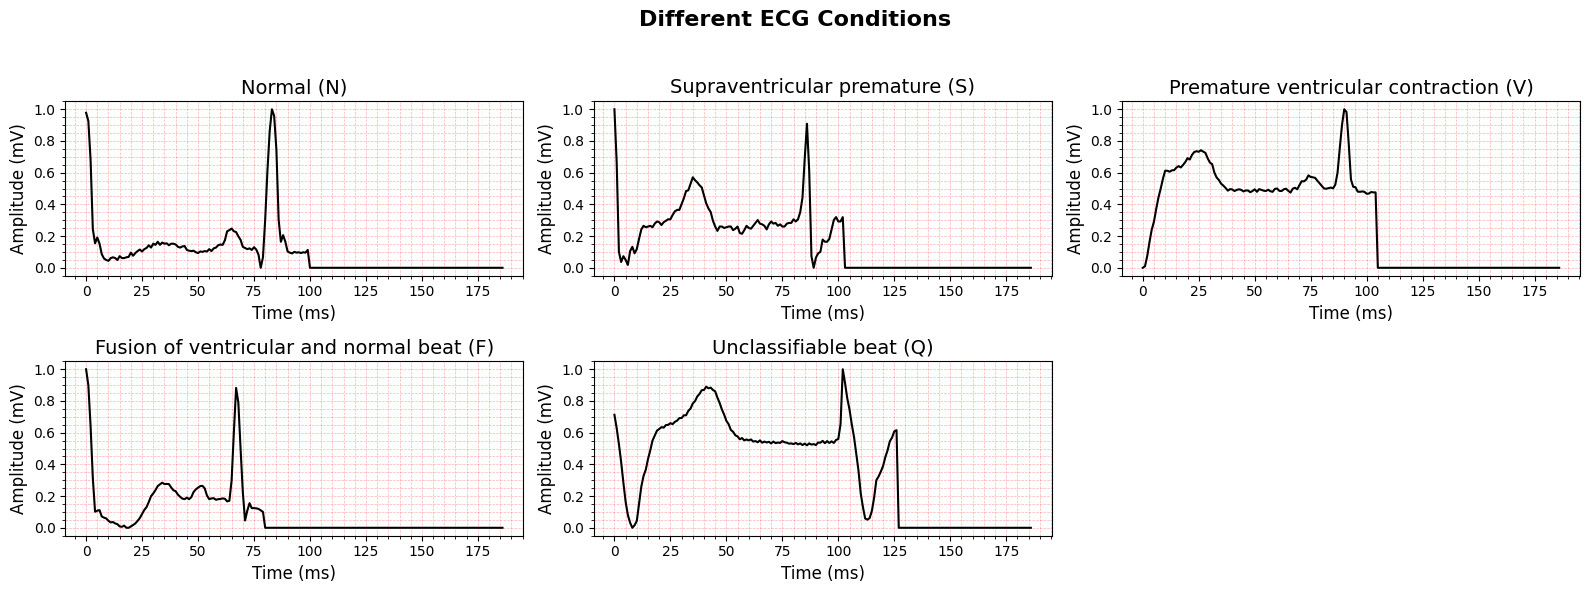

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(16, 6))
for i in range(5):
    row = df[df[187] == i].iloc[0, :187]
    ax = axes[i // 3, i % 3]
    ax.plot(row[0:187], color='black', linewidth=1.5)
    ax.set_title(conditions[i], fontsize=14)
    ax.set_xlabel("Time (ms)", fontsize=12)
    ax.set_ylabel("Amplitude (mV)", fontsize=12)
    ax.grid(which='both', linestyle='--', linewidth=0.5, color='red', alpha=0.3)
    ax.minorticks_on()

fig.suptitle("Different ECG Conditions", fontsize=16, fontweight='bold')
fig.delaxes(axes[-1, -1])
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [13]:
any([df[i].isna().any() for i in range(188)])

False

There is no missing values, and this is reasonable; because all the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.

In [14]:
df.duplicated().any()

np.False_

Also there is no duplicates in the data. This means there is no two or more patients have the same heart rate representation.

### Let's look at the mean shape for every class

In [15]:
grouped_classes = df.groupby(187).mean()
grouped_classes

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
187,,,,,,,,,,,,,,,,,,,,,
0.0,0.915356,0.778014,0.403563,0.177536,0.164311,0.180612,0.180137,0.180581,0.183188,0.188259,...,0.003115,0.002759,0.002444,0.002190,0.001984,0.001809,0.001656,0.001446,0.001250,0.001166
1.0,0.897575,0.781740,0.272035,0.089773,0.151223,0.186248,0.175968,0.200844,0.225769,0.213789,...,0.041799,0.041910,0.042059,0.040974,0.039942,0.039711,0.039222,0.038509,0.037970,0.037959
2.0,0.604474,0.593305,0.516703,0.418160,0.373705,0.365676,0.365940,0.358152,0.339680,0.319964,...,0.027761,0.025323,0.023215,0.021724,0.019467,0.017767,0.016710,0.015829,0.014308,0.013284
3.0,0.924958,0.865178,0.609582,0.342783,0.196000,0.171894,0.156562,0.133611,0.121747,0.115655,...,0.000293,0.000233,0.000154,0.000136,0.000066,0.000066,0.000041,0.000047,0.000022,0.000041
4.0,0.860037,0.663989,0.604526,0.540759,0.478440,0.418510,0.366201,0.306952,0.244817,0.183819,...,0.000016,0.000014,0.000013,0.000013,0.000014,0.000010,0.000000,0.000000,0.000000,0.000000


In [16]:
groups = grouped_classes.index.to_list()
groups

[0.0, 1.0, 2.0, 3.0, 4.0]

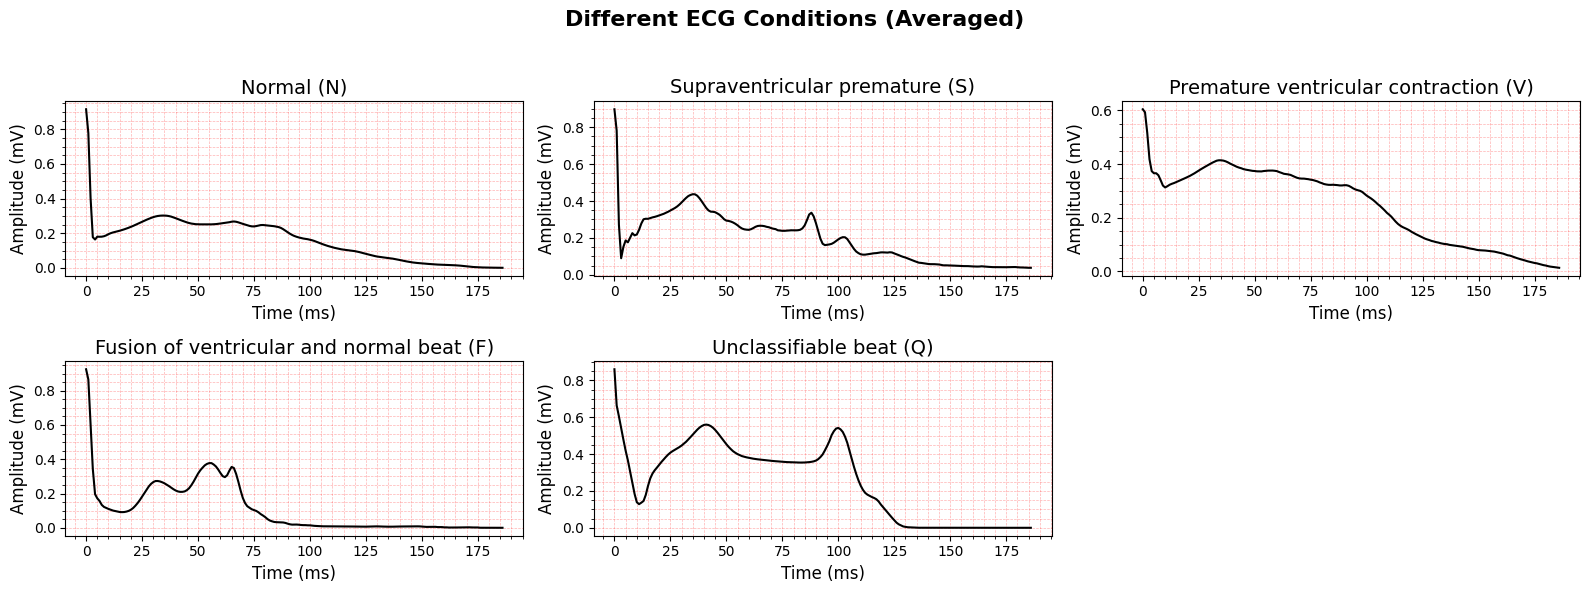

In [17]:
groups = [int(x) for x in grouped_classes.index.to_list()]

fig, axes = plt.subplots(2, 3, figsize=(16, 6))
for i in groups:
    row = grouped_classes.loc[i]
    ax = axes[i // 3, i % 3]
    ax.plot(row[0:], color='black', linewidth=1.5)
    ax.set_title(conditions[i], fontsize=14)
    ax.set_xlabel("Time (ms)", fontsize=12)
    ax.set_ylabel("Amplitude (mV)", fontsize=12)
    ax.grid(which='both', linestyle='--', linewidth=0.5, color='red', alpha=0.3)
    ax.minorticks_on()

fig.suptitle("Different ECG Conditions (Averaged)", fontsize=16, fontweight='bold')
fig.delaxes(axes[-1, -1])
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


It's a disaster! It doesn't look like the original plot at all. We need to normalize values and deal with outliers to fix this plot.

### Let's look at the distribution of each class

In [18]:
df[187].value_counts()

,count
187,
0.0,72471
4.0,6431
2.0,5788
1.0,2223
3.0,641


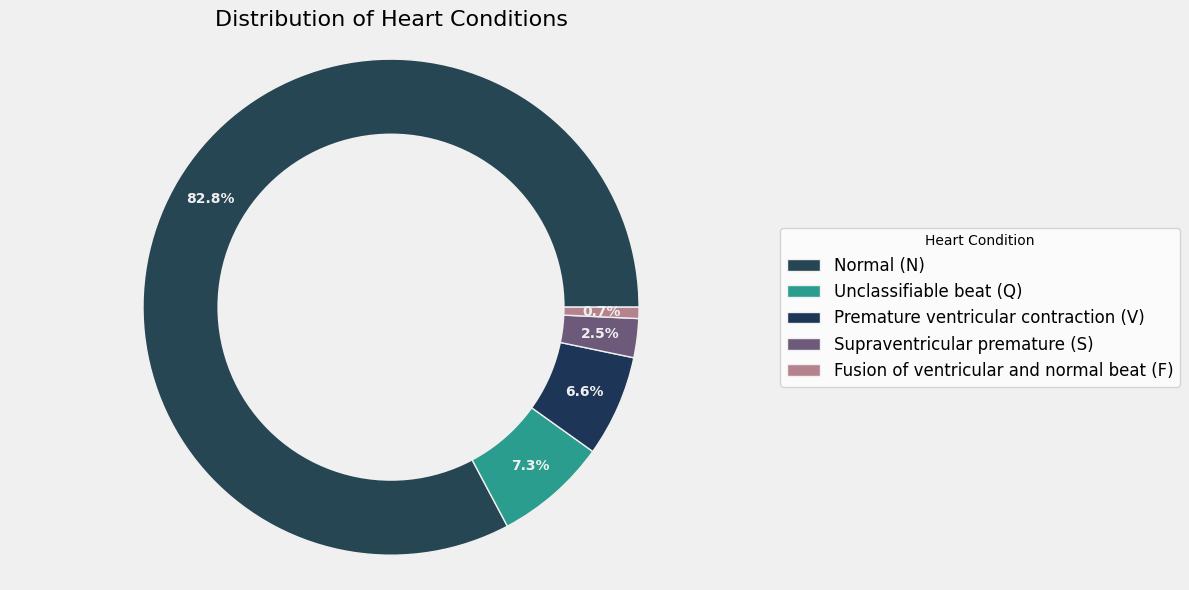

In [19]:
distribution = df[187].value_counts().to_dict()
distribution = {conditions[int(k)]: v for k, v in distribution.items()}

palette = [
    "#264653",  # dark blue-green
    "#2a9d8f",  # teal
    "#1d3557",  # deep navy
    "#6d597a",  # muted purple
    "#b5838d"   # dusty rose
]

fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f0f0f0')
wedges, texts, autotexts = ax.pie(
    list(distribution.values()),
    labels=None,
    colors=palette,
    pctdistance=0.85,
    autopct='%1.1f%%',
    textprops={'color': '#f0f0f0', 'fontweight': 'bold'},
    wedgeprops={'edgecolor': '#f0f0f0'}
)

centre_circle = plt.Circle((0, 0), 0.70, fc='#f0f0f0')
ax.add_artist(centre_circle)

ax.legend(
    wedges,
    list(distribution.keys()),
    title="Heart Condition",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=12
)

plt.title('Distribution of Heart Conditions', fontsize=16, color='black')
plt.axis('equal')
plt.tight_layout()
plt.show()

It's obvious that **Normal** condition is the most class existing in the data.

### More analysis needed!

The goal is to create more visualizations and analyses to capture relationships and patterns in the data. However, I lack the technical medical knowledge necessary to do so. In the future, I plan to consult with a doctor to help me understand the data better and perform more exploratory data analysis (EDA).

## Modeling phase

In [20]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Bagging": BaggingClassifier(random_state=42)
}

In [29]:
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train, sample_weight=sample_weights)
    y_pred = model.predict(X_test)
    print(f"Classification Report for {name}:\n", classification_report(y_test, y_pred, target_names=conditions.values()))

Training Logistic Regression...
Classification Report for Logistic Regression:
                                            precision    recall  f1-score   support

                               Normal (N)       0.97      0.64      0.78     18118
           Supraventricular premature (S)       0.14      0.67      0.24       556
    Premature ventricular contraction (V)       0.30      0.71      0.42      1448
Fusion of ventricular and normal beat (F)       0.08      0.88      0.14       162
                  Unclassifiable beat (Q)       0.73      0.92      0.81      1608

                                 accuracy                           0.67     21892
                                macro avg       0.44      0.76      0.48     21892
                             weighted avg       0.88      0.67      0.74     21892

Training Random Forest...
Classification Report for Random Forest:
                                            precision    recall  f1-score   support

                  

### So, `xgboost` is the best model so far.

In [23]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train, sample_weight=sample_weights)
y_pred = xgb_model.predict(X_test)
print(f"Classification Report for XGBoost:\n", classification_report(y_test, y_pred, target_names=conditions.values()))
y_pred_proba = xgb_model.predict_proba(X_test)
y_pred_proba = pd.DataFrame(y_pred_proba, columns=conditions.values())
y_pred_proba.head()

Classification Report for XGBoost:
                                            precision    recall  f1-score   support

                               Normal (N)       0.99      0.99      0.99     14579
           Supraventricular premature (S)       0.82      0.81      0.81       426
    Premature ventricular contraction (V)       0.94      0.94      0.94      1112
Fusion of ventricular and normal beat (F)       0.85      0.81      0.83       145
                  Unclassifiable beat (Q)       0.99      0.98      0.98      1249

                                 accuracy                           0.98     17511
                                macro avg       0.92      0.91      0.91     17511
                             weighted avg       0.98      0.98      0.98     17511



,Normal (N),Supraventricular premature (S),Premature ventricular contraction (V),Fusion of ventricular and normal beat (F),Unclassifiable beat (Q)
0,0.973872,0.025605,0.000089,0.000425,0.000009
1,0.996564,0.003415,0.000001,0.000015,0.000005
2,0.987114,0.003176,0.008603,0.000920,0.000187
3,0.938707,0.061082,0.000064,0.000121,0.000026
4,0.000176,0.000004,0.000012,0.000002,0.999806


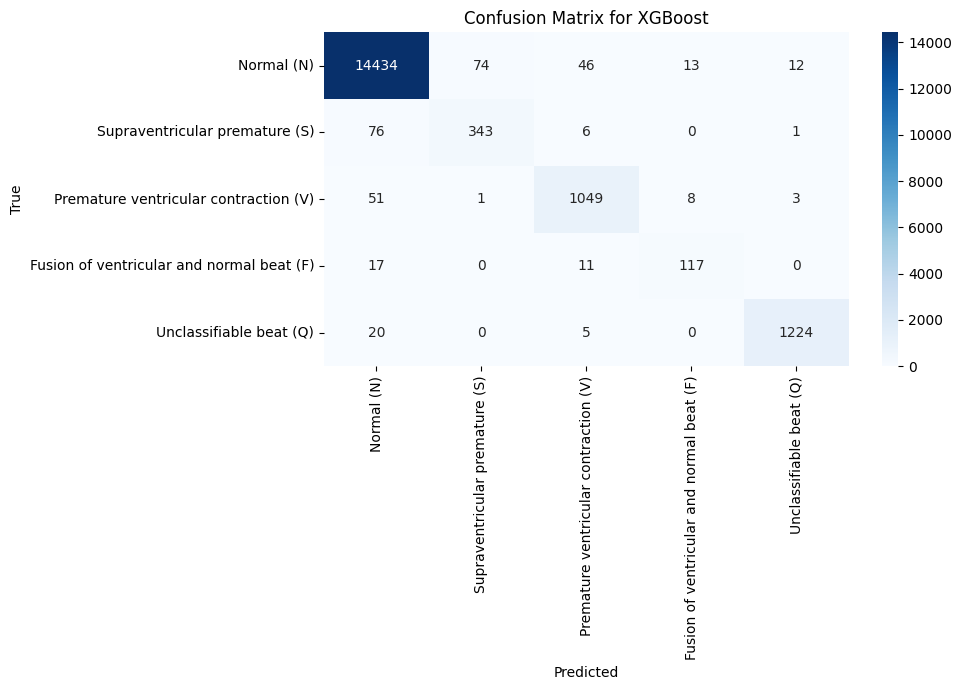

In [24]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=conditions.values(), yticklabels=conditions.values())
plt.title("Confusion Matrix for XGBoost")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [26]:
# Change the path to load the test data from Google Drive
df_test = pd.read_csv("/content/drive/MyDrive/archive (1)/mitbih_test.csv", header=None)
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


                                           precision    recall  f1-score   support

                               Normal (N)       0.99      0.99      0.99     18118
           Supraventricular premature (S)       0.79      0.78      0.78       556
    Premature ventricular contraction (V)       0.95      0.95      0.95      1448
Fusion of ventricular and normal beat (F)       0.81      0.81      0.81       162
                  Unclassifiable beat (Q)       0.99      0.98      0.98      1608

                                 accuracy                           0.98     21892
                                macro avg       0.91      0.90      0.90     21892
                             weighted avg       0.98      0.98      0.98     21892



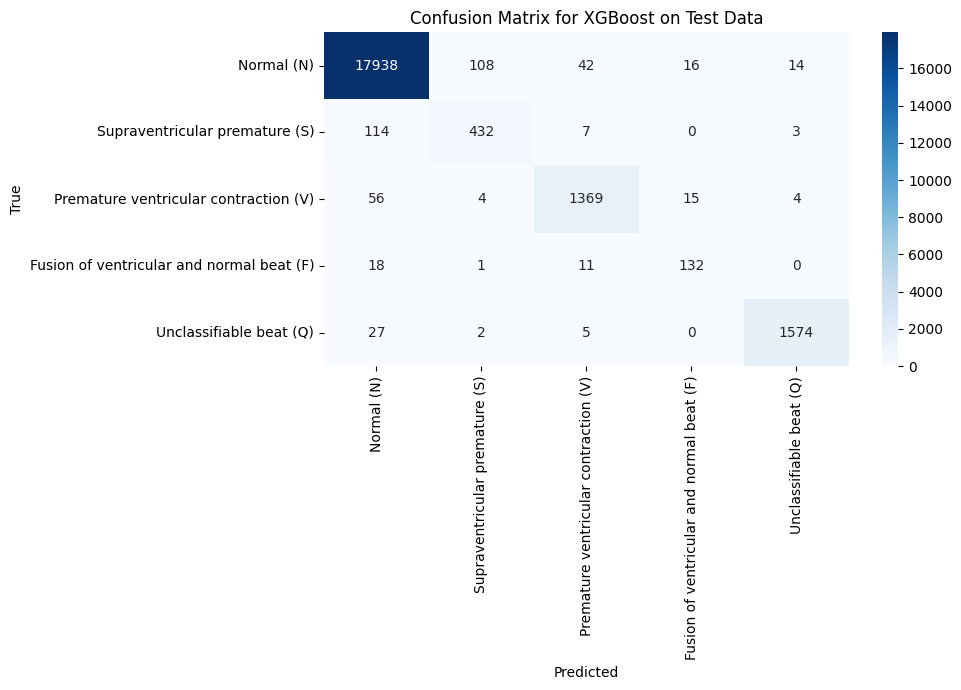

In [27]:
y_test = df_test.iloc[:, -1]
X_test = df_test.iloc[:, :-1]
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=conditions.values()))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=conditions.values(), yticklabels=conditions.values())
plt.title("Confusion Matrix for XGBoost on Test Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

Here we get to the end of the notebook, I hope you enjoyed it and learnt something from it.

Thank you, and don't forget an upvote if you find it useful 😍